# Analyzing Geospatial Data (Parks)

This tutorial demostrates how to work with and analyze geospatial data ([spatial analytics](https://en.wikipedia.org/wiki/Spatial_analysis)) in Python to derive insights about place. Specifically, we will use NYC's open data platform to download park locations across the city, merge this with income level data, and then display simple insights about the relationship between open space (parks) and income.

*Note: this example assumes you have the necessary Python librararies installed while doing the [Mapping Census Data](https://nbviewer.jupyter.org/github/carlobailey/urban-data-science/blob/gh-pages/tutorials/Mapping_Census_Data.ipynb) tutorial.*

### Step 1: Downloading open space (parks) data and installing SODA

We will begin by importing all the necessary libraries and calling the Socrata API (1) to access the data directly in this notebook.

You will also need to install the following:
- [soda](https://pypi.org/project/sodapy/)
- [scipy](https://www.scipy.org/install.html) 


*(1) The [Socrata API](https://dev.socrata.com/) gives programmers, researchers, or any member of the public the ability to access government data programatically (through code).*

In [1]:
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd
import matplotlib.pyplot as plt
from sodapy import Socrata
import cenpy
from shapely.geometry import shape
from scipy.stats import pearsonr

In [2]:
client = Socrata("data.cityofnewyork.us", None)

In [3]:
# request park geo data: instructions https://dev.socrata.com/foundry/data.cityofnewyork.us/y6ja-fw4f
results = client.get("y6ja-fw4f", limit=20000)
park_df = pd.DataFrame.from_records(results)

In [4]:
park_df['the_geom'] = park_df['the_geom'].apply(lambda x: shape(x))

In [5]:
print(park_df.shape)
park_df.head(1)

(12491, 11)


,park_name,the_geom,feat_code,source_id,sub_code,landuse,parknum,status,shape_leng,shape_area,system
0,Commodore Barry Park,(POLYGON ((-73.97922375065221 40.6979987936995...,4910,21491000001,491050,Community Park,B021,Updated,829.420106841,41539.8013629,NaN


### Step 2: Geocoding data

The next step is to [geocode](https://en.wiktionary.org/wiki/geocode) the data – which basically means to assign each park in our data a corresponding zipcode (we could have chosen some other geographic level such as census tract, block, metro, etc.)

To do this we will need to download [zip code geometries](https://drive.google.com/file/d/16b3l5_JwUNwr4T9nqoBjKLB30miB6i2-/view?usp=sharing), and then use the centroid of the park to located the zip code it falls within.

In [18]:
# Load downloaded zip code geo
path = 'data/us_zipcodes.geojson' 
gdf = gpd.read_file(path)
print(gdf.shape)
gdf.head(1)

(33144, 11)


,region_id,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,53922,53922,53922,B5,G6350,S,118603010,1919478,43.52093,-88.715147,"POLYGON ((-88.79170 43.53140, -88.79127 43.531..."


In [7]:
# Create park centroids
park_df['centroid'] = park_df['the_geom'].apply(lambda x: x.centroid)
park_gdf = gpd.GeoDataFrame(park_df, geometry='centroid')

In [8]:
park_gdf = park_gdf.set_crs(epsg=2263)

In [23]:
# Geocode park data
combined_gdf = gpd.sjoin(park_gdf, gdf, op='within', how='inner')

In [25]:
combined_gdf.head(1)

,park_name,the_geom,feat_code,source_id,sub_code,landuse,parknum,status,shape_leng,shape_area,...,region_id,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND,AWATER,INTPTLAT,INTPTLON
0,Commodore Barry Park,(POLYGON ((-73.97922375065221 40.6979987936995...,4910,21491000001,491050,Community Park,B021,Updated,829.420106841,41539.8013629,...,11205,11205,11205,B5,G6350,S,2447347,0,40.694662,-73.966241


In [76]:
combined_gdf.shape

(12229, 23)

In [78]:
combined_gdf[combined_gdf['landuse'].isin(
    ['Recreation Field/Courts', 'Community Park', 
     'Garden', 'Playground', 'LARGE PARK AREA'])].shape

(1217, 23)

### Step 3: Aggregate park area by zipcode

Next we will calculate the total park area by zipcode.

In [29]:
# convert 'shape_area' column to a float
combined_gdf['shape_area'] = combined_gdf['shape_area'].astype(float)

In [48]:
zip_code_park_area = combined_gdf.groupby(
    'ZCTA5CE10')['shape_area'].sum().reset_index()

### Step 4: Download and merge zipcode income & population data

Lets now download [ACS](https://en.wikipedia.org/wiki/American_Community_Survey) population and income level data at the zipcode level. We will use it to surface simple patterns in the data.

In [122]:
conn = cenpy.products.APIConnection("ACSDT5Y2018")
pop_income = conn.query(['B01003_001E', 'B19013_001E', 'B19025_001E'], 
                  geo_unit='zip code tabulation area')
# rename columns for readability
pop_income.rename(columns={'zip code tabulation area': 'zcta'}, inplace=True)
pop_income.rename(columns={'B01003_001E': 'total_pop',
                           'B19013_001E': 'income',
                           'B19025_001E': 'agg_income'}, inplace=True)
pop_income.shape

(33120, 4)

In [140]:
pop_income.replace(-666666666.0, np.nan, inplace=True)

In [141]:
pop_income['total_pop'] = pop_income['total_pop'].astype(float)
pop_income['income'] = pop_income['income'].astype(float)
pop_income['agg_income'] = pop_income['agg_income'].astype(float)

In [142]:
results = zip_code_park_area.merge(pop_income, 
                                   left_on='ZCTA5CE10', 
                                   right_on='zcta')

### Step 5: Calculate park area and income level per person (per capita)

Next we will calculate park area and income level per capita. Per capita reporting is most often used in economic analysis to compare countires with varying population sizes. It gives the ability to compare apples to apples despite those differences.

In [143]:
results['park_capita'] = results['shape_area'] / results['total_pop']
results['income_capita'] = results['income'] / results['total_pop']
results['agg_income_capita'] = results['agg_income'] / results['total_pop']

In [144]:
results.replace([np.inf, -np.inf], np.nan, inplace=True)

### Step 6: Describe the data with simple statistics

Finally, now that we have all the data and it's in a format we want, we can begin describing it with simple statistics. For example, we can now plot the average park area per person throughout the city and how the average park area differs by income level, and look at the correlation coefficient between income per capita and park area per capita.

*Note: we will save charts as PDF files so that you can further edit them in Illustrator or a similar program. You could do this in Python but it would be beyond the scope of this example.*

In [145]:
# Average park area per person across NYC
print('Park area per person in NYC is: %s' % (results['shape_area'].sum() / results['total_pop'].sum()))

Park area per person in NYC is: 126.46707233920166


In [146]:
above_avg = results[results['agg_income_capita'].quantile(0.5) > results['agg_income_capita']]['park_capita'].mean()
below_avg = results[results['agg_income_capita'].quantile(0.5) < results['agg_income_capita']]['park_capita'].mean()

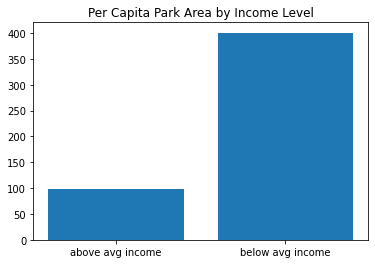

In [147]:
plt.bar(['above avg income', 'below avg income'], [above_avg, below_avg])
plt.title('Per Capita Park Area by Income Level')
# Save to a PDF file
plt.savefig('per_capita_park_by_income.pdf')

In [161]:
above_75 = results[results['agg_income_capita'].quantile(0.75) > results['agg_income_capita']]['park_capita'].mean()
below_25 = results[results['agg_income_capita'].quantile(0.25) < results['agg_income_capita']]['park_capita'].mean()

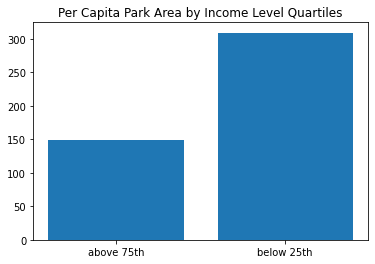

In [170]:
plt.bar(['above 75th', 'below 25th'], [above_75, below_25])
_ = plt.title('Per Capita Park Area by Income Level Quartiles')
# Save to a PDF file
# plt.savefig('per_capita_park_by_income.pdf')

In [178]:
pearsonr(results.dropna()['agg_income'], 
         results.dropna()['park_capita'])

(-0.11208446964820368, 0.135229648708372)

<AxesSubplot:>

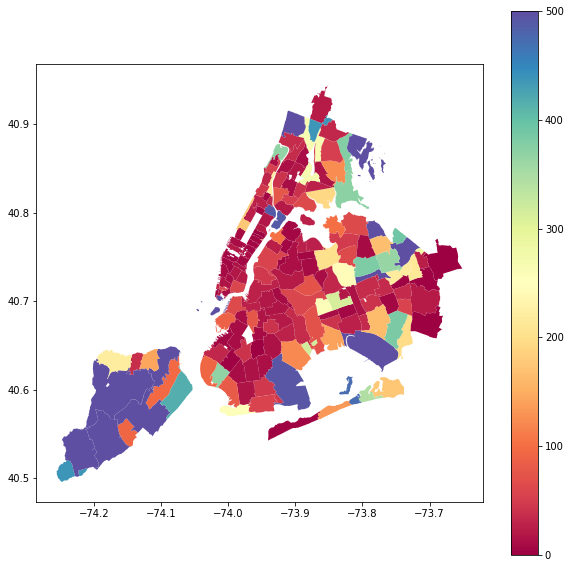

In [190]:
gdf.merge(results, on='ZCTA5CE10').plot(column='park_capita', 
                                        vmin=0, vmax=500, cmap='Spectral',
                                        legend=True, figsize=(10, 10))